In [ ]:
#Objective: Build a movie review analysis system that classifies reviews and provides insights.
#1- Simple approach: TF-IDF + Logistic Regression
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
import re

In [ ]:
def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

In [ ]:
df['clean_review'] = df['review'].apply(preprocess_text)

In [ ]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
x = df['clean_review']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
model = LogisticRegression()
model.fit(x_train_tfidf, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_tfidf)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8966


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
#2- Word Embeddings
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt', force = True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.data.path.append('/tmp/nltk_data')

In [ ]:
def get_document_vector(text, model, dim=25):
    words = text.split()  # Use simple whitespace split
    valid_words = [w for w in words if w in model]
    if not valid_words:
        return np.zeros(dim)
    return np.mean([model[w] for w in valid_words], axis=0)

In [ ]:
doc_embeddings = np.array([get_document_vector(text, glove_vectors) for text in df['clean_review']])

In [ ]:
from collections import Counter

In [ ]:
all_words = ' '.join(df['clean_review']).split()

In [ ]:
top_100_words = [word for word, freq in Counter(all_words).most_common(200) if word in glove_vectors][:100]

In [ ]:
top_100_vectors = np.array([glove_vectors[word] for word in top_100_words])

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
top_100_2d = tsne.fit_transform(top_100_vectors)

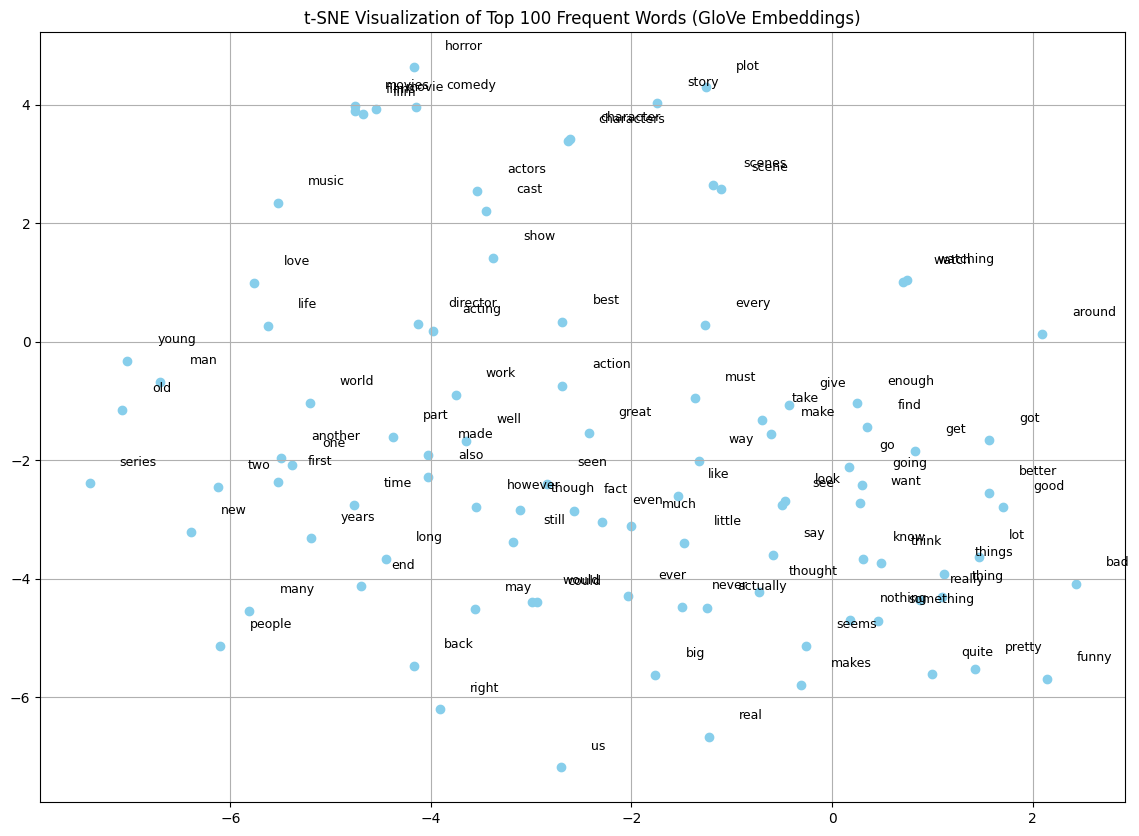

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.scatter(top_100_2d[:, 0], top_100_2d[:, 1], color='skyblue')

for i, word in enumerate(top_100_words):
    plt.text(top_100_2d[i, 0]+0.3, top_100_2d[i, 1]+0.3, word, fontsize=9)

plt.title("t-SNE Visualization of Top 100 Frequent Words (GloVe Embeddings)")
plt.grid(True)
plt.show()


In [ ]:
#3- ANN Implementation
X = doc_embeddings
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(100,)),  # change 25 to 100
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6352 - loss: 0.6255 - val_accuracy: 0.7790 - val_loss: 0.4679
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7766 - loss: 0.4750 - val_accuracy: 0.7955 - val_loss: 0.4517
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7853 - loss: 0.4609 - val_accuracy: 0.7965 - val_loss: 0.4440
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7943 - loss: 0.4494 - val_accuracy: 0.7873 - val_loss: 0.4577
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7987 - loss: 0.4430 - val_accuracy: 0.8012 - val_loss: 0.4413
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7940 - loss: 0.4527 - val_accuracy: 0.8008 - val_loss: 0.4364
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8026 - loss: 0.4397 - val_accuracy: 0.8022 - val_loss: 0.4364
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7997 - loss: 0.4413 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4961
           1       0.81      0.79      0.80      5039

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
#4- CNN for Text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
texts = df['clean_review'].values
labels = df['label'].values

In [ ]:
vocab_size = 10000
maxlen = 200

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [ ]:
embedding_dim = 100

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    verbose=1
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 381ms/step - accuracy: 0.6563 - loss: 0.5861 - val_accuracy: 0.8608 - val_loss: 0.3192
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 364ms/step - accuracy: 0.8845 - loss: 0.2817 - val_accuracy: 0.8764 - val_loss: 0.2908
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 371ms/step - accuracy: 0.9343 - loss: 0.1827 - val_accuracy: 0.8739 - val_loss: 0.3174
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 374ms/step - accuracy: 0.9641 - loss: 0.1103 - val_accuracy: 0.8697 - val_loss: 0.3628
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 371ms/step - accuracy: 0.9804 - loss: 0.0628 - val_accuracy: 0.8641 - val_loss: 0.4614


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      4961
           1       0.84      0.90      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [ ]:
#Part C- Text Summaarisation
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

In [ ]:
long_reviews = df[df['word_count'] > 200]['review'].reset_index(drop=True)

In [ ]:
print(f"📝 Found {len(long_reviews)} long reviews (200+ words)")

📝 Found 20430 long reviews (200+ words)


In [ ]:
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os

In [ ]:
# Force set a known good nltk_data directory
nltk_data_path = '/usr/local/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)

# Set this path as the nltk data path
nltk.data.path.append(nltk_data_path)

# Now force download of 'punkt'
nltk.download('punkt', download_dir=nltk_data_path)

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def simple_sentence_tokenize(text):
    # Splits text at sentence boundaries based on punctuation
    return re.split(r'(?<=[.!?])\s+', text.strip())

def textrank_summarize(text, num_sentences=3):
    sentences = simple_sentence_tokenize(text)

    if len(sentences) <= num_sentences:
        return text

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)

    sim_matrix = cosine_similarity(tfidf_matrix)
    np.fill_diagonal(sim_matrix, 0)

    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    top_sentences = [s for _, s in ranked_sentences[:num_sentences]]

    return " ".join(top_sentences)


In [ ]:
for i in range(3):
    original = long_reviews[i]
    summary = textrank_summarize(original, num_sentences=3)

    print(f"\n🔹 ORIGINAL REVIEW ({len(original.split())} words):\n")
    print(original[:800], '...')
    print("\n🔸 SUMMARY:\n")
    print(summary)
    print("-" * 100)


🔹 ORIGINAL REVIEW (307 words):

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas,  ...

🔸 SUMMARY:

Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penite